# Kaggle Setup

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d greg115/pix2pix-depth

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 1.41G/1.41G [01:15<00:00, 21.2MB/s]
100% 1.41G/1.41G [01:15<00:00, 20.0MB/s]


In [ ]:
!unzip pix2pix-depth.zip

Streaming output truncated to the last 5000 lines.
  inflating: pix2pix-depth/pix2pix-depth/training/24214843.png  
  inflating: pix2pix-depth/pix2pix-depth/training/24214844.png  
  inflating: pix2pix-depth/pix2pix-depth/training/24224845.png  
  inflating: pix2pix-depth/pix2pix-depth/training/24224846.png  
  inflating: pix2pix-depth/pix2pix-depth/training/24234847.png  
  inflating: pix2pix-depth/pix2pix-depth/training/24234848.png  
  inflating: pix2pix-depth/pix2pix-depth/training/24244849.png  
  inflating: pix2pix-depth/pix2pix-depth/training/24244850.png  
  inflating: pix2pix-depth/pix2pix-depth/training/242485.png  
  inflating: pix2pix-depth/pix2pix-depth/training/242486.png  
  inflating: pix2pix-depth/pix2pix-depth/training/24264853.png  
  inflating: pix2pix-depth/pix2pix-depth/training/24264854.png  
  inflating: pix2pix-depth/pix2pix-depth/training/24274855.png  
  inflating: pix2pix-depth/pix2pix-depth/training/24274856.png  
  inflating: pix2pix-depth/pix2pix-depth/tr

# Importing Dependices

In [ ]:
try:
    import torch
    from torch import nn
    from torchvision import transforms
except:
    !pip install torch torchvision
    import torch
    from torch import nn
    from torchvision import transforms

In [ ]:
from torch.utils.data import DataLoader
from PIL import Image
from typing import List, Tuple, Dict
import os
from glob import glob
import numpy as np
from statistics import mean
from tqdm import tqdm
from torchvision.utils import save_image

In [ ]:
# try:
#     import gradio as gr
# except:
#     !pip install -q gradio
#     import gradio as gr

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# !unzip pix2pix-depth.zip

# Creating Dataset

In [ ]:
def show_img_sample(img: torch.Tensor, img1: torch.Tensor):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    ax = axes.ravel()
    ax[0].imshow(img.permute(1, 2, 0))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("input image", c="g")
    ax[1].imshow(img1.permute(1, 2, 0))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("label image", c="g")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [ ]:
data_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5,))
        ])

In [ ]:
def read_path(filepath):
    root_path = "pix2pix-depth/pix2pix-depth/"
    path = os.path.join(root_path, filepath)
    dataset = []
    for p in glob(path+"/"+"*.png"):
        dataset.append(p)
    return dataset

In [ ]:
TRAIN_DIR = "pix2pix-depth/training"
VAL_DIR = "pix2pix-depth/validation"
class Dataset(object):
    def __init__(self, files):
        self.files = files
        self.trasformer = data_transform

    def _separate(self, img):
        img = np.array(img, dtype=np.uint8)
        h, w, _ = img.shape
        w = int(w/2)
        return Image.fromarray(img[:, w:, :]), Image.fromarray(img[:, :w, :])

    def __getitem__(self, idx: int):
        img = Image.open(self.files[idx])
        output,input = self._separate(img)
        input_tensor = self.trasformer(input)
        output_tensor = self.trasformer(output)
        return input_tensor, output_tensor

    def __len__(self):
        return len(self.files)

In [ ]:
# class CreateDataset(Dataset):
#     def __init__(self, root_dir):
#         self.root_dir = root_dir
#         self.list_files = os.listdir(self.root_dir)

#     def __len__(self):
#         return len(self.list_files)

#     def __getitem__(self, index):
#         img_file = self.list_files[index]
#         img_path = os.path.join(self.root_dir, img_file)
#         image = np.array(Image.open(img_path))
#         input_image = image[:, :600, :]
#         target_image = image[:, 600:, :]

#         augmentations = both_transform(image=input_image, image0=target_image)
#         input_image = augmentations["image"]
#         target_image = augmentations["image0"]

#         input_image = transform_only_input(image=input_image)["image"]
#         target_image = transform_only_mask(image=target_image)["image"]

#         return input_image, target_image

In [ ]:
train_files=read_path('training')
# train_files=train_files[:1000]
dataset = Dataset(train_files)
# loader = DataLoader(dataset, batch_size=5)

In [ ]:
print(len(train_files))

6686


In [ ]:
x,y=dataset.__getitem__(10)

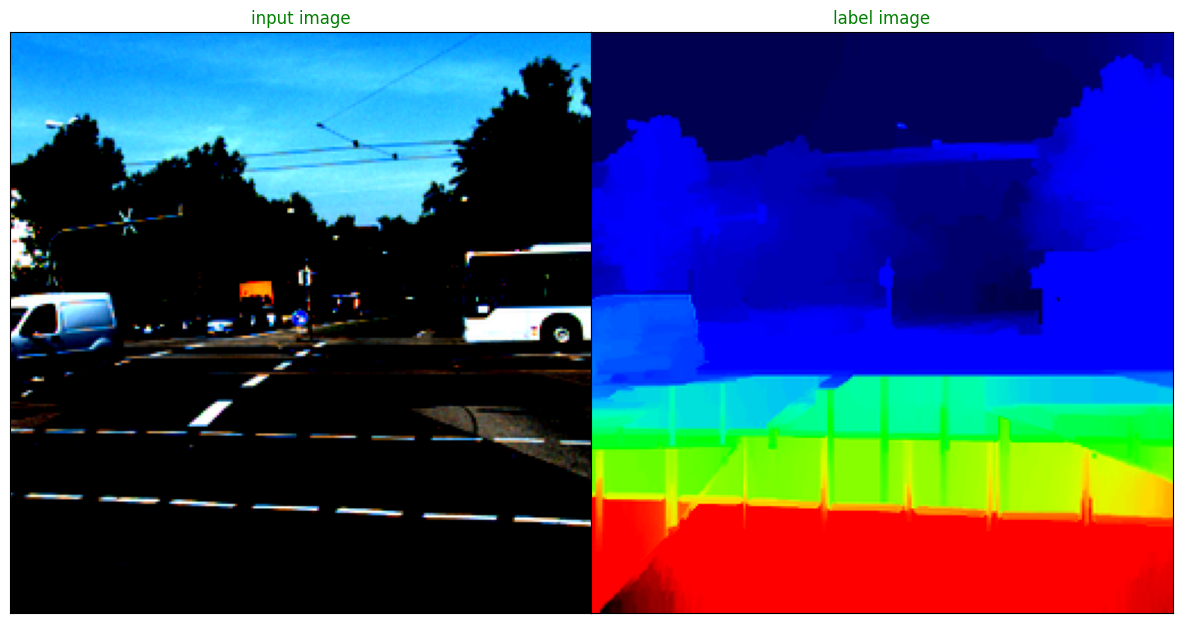

In [ ]:
show_img_sample(x,y)

# Generator Model

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

# Discriminator Model

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self,in_channels,out_channels,stride=2):
    super().__init__()
    self.conv_layer=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,4,stride,bias=False,padding_mode='reflect'),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
  def forward(self,x):
    return self.conv_layer(x)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,
               in_channels=3):
    super().__init__()
    self.model=nn.Sequential(
        nn.Conv2d(in_channels*2,64,kernel_size=4,stride=2,padding_mode="reflect",),
        nn.LeakyReLU(0.2),
        ConvBlock(64,128,stride=2),
        ConvBlock(128,256,stride=2),
        ConvBlock(256,512,stride=1),
        nn.Conv2d(512,1,kernel_size=4,stride=1,padding=1,padding_mode="reflect"),
        nn.Sigmoid()
    )
  def forward(self,x,y):
    x=torch.cat([x,y],dim=1)
    return self.model(x)

# Building the Model

In [ ]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 500
LOAD_MODEL = False
SAVE_MODEL = False
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"

In [ ]:
# g_loss=[]
# d_loss=[]

In [ ]:
def train_fn(train_dl, G, D, criterion_bce, criterion_mae, optimizer_g, optimizer_d):
    G.train()
    D.train()
    LAMBDA=100.0
    total_g_loss=[]
    total_d_loss=[]
    for i,(input_image,real_image) in enumerate(tqdm(train_dl)):
        input_image=input_image.to(device)
        real_image=real_image.to(device)

        real_label=torch.ones(input_image.size()[0],1,26,26,device=device)
        fake_label=torch.zeros(input_image.size()[0], 1, 26, 26,device=device)
        # Generator
        fake_img=G(input_image)
        fake_img_ = fake_img.detach()
        out_fake = D(fake_img, input_image)
        loss_g_bce = criterion_bce(out_fake, real_label) # binaryCrossEntropy
        loss_g_mae = criterion_mae(fake_img, real_image) # MSELoss
        loss_g = loss_g_bce + LAMBDA * loss_g_mae
        total_loss_g.append(loss_g.item())

        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_g.backward(retain_graph=True)
        optimizer_g.step()
        # Dicriminator
        out_real=D(real_image,input_image)
        loss_d_real=criterion_bce(out_real, real_label)
        out_fake = D(fake_img_, input_image)
        loss_d_fake = criterion_bce(out_fake, fake_label)
        loss_d = loss_d_real + loss_d_fake
        total_loss_d.append(loss_d.item())

        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
    return mean(total_loss_g), mean(total_loss_d), fake_img.detach().cpu()

In [ ]:
def save_img(fake_img, e):
    os.makedirs("generated", exist_ok=True)
    save_image(fake_img, f"generated/fake{str(e)}.png", range=(-1.0, 1.0), normalize=True)

In [ ]:
def save_logs(result):
    with open("train.pkl", "wb") as f:
        pickle.dump([result], f)

In [ ]:
def save_model(D, G, e):
    os.makedirs("weight", exist_ok=True)
    torch.save(G.state_dict(), f"weight/G{str(e+1)}.pth")
    torch.save(D.state_dict(), f"weight/D{str(e+1)}.pth")

In [ ]:
def show_losses(g, d):
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    ax = axes.ravel()
    ax[0].plot(np.arange(len(g)).tolist(), g)
    ax[0].set_title("Generator Loss")
    ax[1].plot(np.arange(len(d)).tolist(), d)
    ax[1].set_title("Discriminator Loss")
    plt.show()

# Training the Model

In [ ]:
G=Generator()
D=Discriminator()

In [ ]:
EPOCHS = 200
betas=(0.5, 0.999)
lr=0.002
BATCH_SIZE=16

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
print(device)

cuda


In [ ]:
G.to(device)
D.to(device)
train_dl = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,num_workers=4)
optimizer_g = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
optimizer_d = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)
criterion_mae = nn.L1Loss()
criterion_bce = nn.BCEWithLogitsLoss()
total_loss_d, total_loss_g = [], []
result = {}

In [ ]:
for epoch in range(EPOCHS):
    loss_g,loss_d,fake_img=train_fn(train_dl,G,D,criterion_bce,criterion_mae,optimizer_g,optimizer_d)
    total_loss_d.append(loss_d)
    total_loss_g.append(loss_g)
    save_img(fake_img,epoch+1)
    if epoch%10==0:
        save_model(D,G,epoch)

 86%|████████▌ | 358/417 [03:08<00:31,  1.90it/s]

In [ ]:
result["G"] = total_loss_d
result["D"] = total_loss_g
# saving_logs(result)
show_losses(total_loss_g, total_loss_d)
# saving_model(D, G, e)
# print("successfully save model")
# return G, D

In [ ]:
!nvidia-smi

Thu May 11 04:09:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    26W /  70W |   3335MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------